In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Downloading historical data
def fetch_data(ticker, period, interval):
    df = yf.download(ticker, period=period, interval=interval)
    df.dropna(inplace=True)
    return df

# Valuation calculation

def get_stock_data(ticker: str) -> dict:
    stock = yf.Ticker(ticker)
    info = stock.info

    price = info.get('currentPrice', 0)
    book_value = info.get('bookValue')
    total_revenue = info.get('totalRevenue')
    shares_outstanding = info.get('sharesOutstanding')

    # Raw ratios from API

    pb_api = info.get('priceToBook')
    ps_api = info.get('priceToSalesTrailing12Months')

    # --- Fallback Logic for PB Ratio ---

    if pb_api is None or pb_api <= 0 or pb_api > 100:
        pb_ratio = price / book_value if price and book_value else 0
    else:
        pb_ratio = pb_api

    # --- Fallback Logic for PS Ratio ---
    
    if ps_api is None or ps_api <= 0 or ps_api > 100:
        if total_revenue and shares_outstanding:
            revenue_per_share = total_revenue / shares_outstanding
            ps_ratio = price / revenue_per_share if revenue_per_share else 0
        else:
            ps_ratio = 0
    else:
        ps_ratio = ps_api

    return {
        'EPS': info.get('trailingEps', 0),
        'PE_ratio': info.get('trailingPE', 0),
        'PB_ratio': round(pb_ratio, 2),
        'PS_ratio': round(ps_ratio, 2),
        'Dividend_yield': info.get('dividendYield', 0),
        'Sector': info.get('sector', 'Unknown'),
        'Price': price
    }

def dcf_valuation(eps: float, growth: float, discount: float, years: int = 5) -> float:
    if eps <= 0:
        return 0
    cash_flows = [(eps * (1 + growth) ** i) / (1 + discount) ** i for i in range(1, years + 1)]
    terminal_value = (cash_flows[-1] * (1 + growth)) / (discount - growth)
    total_value = sum(cash_flows) + terminal_value / (1 + discount) ** years
    return round(total_value, 2)

def gordon_growth(dividend_yield: float, price: float, growth: float, discount: float) -> float:
    if dividend_yield <= 0 or price <= 0 or discount <= growth:
        return 0
    dividend = price * dividend_yield
    value = dividend * (1 + growth) / (discount - growth)
    return round(value, 2)

def relative_pe_tag(stock_pe: float, sector_pe: float = 25.0) -> str:
    if stock_pe <= 0:
        return "Insufficient data"
    delta = stock_pe - sector_pe
    if delta < -5:
        return "Undervalued"
    elif delta > 5:
        return "Overvalued"
    else:
        return "Fairly Priced"

def valuation_verdict(dcf_value: float, market_price: float) -> str:
    if dcf_value <= 0 or market_price <= 0:
        return "Insufficient data"
    
    delta = (dcf_value - market_price) / market_price

    if delta >= 0.20:
        return "Undervalued"
    elif delta <= -0.20:
        return "Overvalued"
    else:
        return "Fairly Priced"

def run_pipeline(ticker: str):
    data = get_stock_data(ticker)
    eps = data['EPS']
    pe = data['PE_ratio']
    pb = data['PB_ratio']
    ps = data['PS_ratio']
    dy = data['Dividend_yield']
    price = data['Price']

    dcf_val = dcf_valuation(eps, growth=0.10, discount=0.12)
    ggm_val = gordon_growth(dy, price, growth=0.05, discount=0.10)
    tag = relative_pe_tag(pe)
    verdict = valuation_verdict(dcf_val, price)

    print(f"\nValuation Summary for {ticker}\n")
    print(f" Intrinsic Value (DCF): ₹{dcf_val}")
    print(f" Dividend Value (GGM): ₹{ggm_val}")
    print(f" Relative Valuation: {tag}")
    print(f" Valuation Verdict (DCF vs Price): {verdict}\n")
    print("Raw Metrics:\n")
    print(f"  EPS: {eps}")
    print(f"  PE Ratio: {pe}")
    print(f"  PB Ratio: {pb}")
    print(f"  PS Ratio: {ps}")
    print(f"  Dividend Yield: {dy}")
    print(f"  Sector: {data['Sector']}")
    print(f"  Current Price: ₹{price}\n")

# SMA and EMA

def calculate_ma(df, sma_period=50, ema_period=20):
    df['SMA'] = df['Close'].rolling(window=sma_period).mean()
    df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()
    return df

# MACD

def calculate_macd(df, fast=12, slow=26, signal=9):
    ema_fast = df['Close'].ewm(span=fast, adjust=False).mean()
    ema_slow = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = ema_fast - ema_slow
    df['Signal'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    df['Histogram'] = df['MACD'] - df['Signal']
    return df

# Plot MA with price
def plot_ma(df, ticker='AAPL'):
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['Close'], label='Close Price', color='black')
    plt.plot(df.index, df['SMA'], label='SMA (50)', color='blue')
    plt.plot(df.index, df['EMA'], label='EMA (20)', color='orange')
    plt.title(f'{ticker} - Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot MACD
def plot_macd(df, ticker='AAPL'):
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['MACD'], label='MACD Line', color='blue')
    plt.plot(df.index, df['Signal'], label='Signal Line', color='orange')
    plt.bar(df.index, df['Histogram'], label='Histogram', color='gray', width=1.5)
    plt.title(f'{ticker} - MACD Indicator')
    plt.xlabel('Date')
    plt.ylabel('MACD Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\heman_q\AppData\Local\Temp\ipykernel_24972\3686209563.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed



Valuation Summary for TCS.NS

 Intrinsic Value (DCF): ₹4533.42
 Dividend Value (GGM): ₹128205.97
 Relative Valuation: Fairly Priced
 Valuation Verdict (DCF vs Price): Undervalued

Raw Metrics:

  EPS: 136.31
  PE Ratio: 22.172255
  PB Ratio: 11.17
  PS Ratio: 4.27
  Dividend Yield: 2.02
  Sector: Technology
  Current Price: ₹3022.3



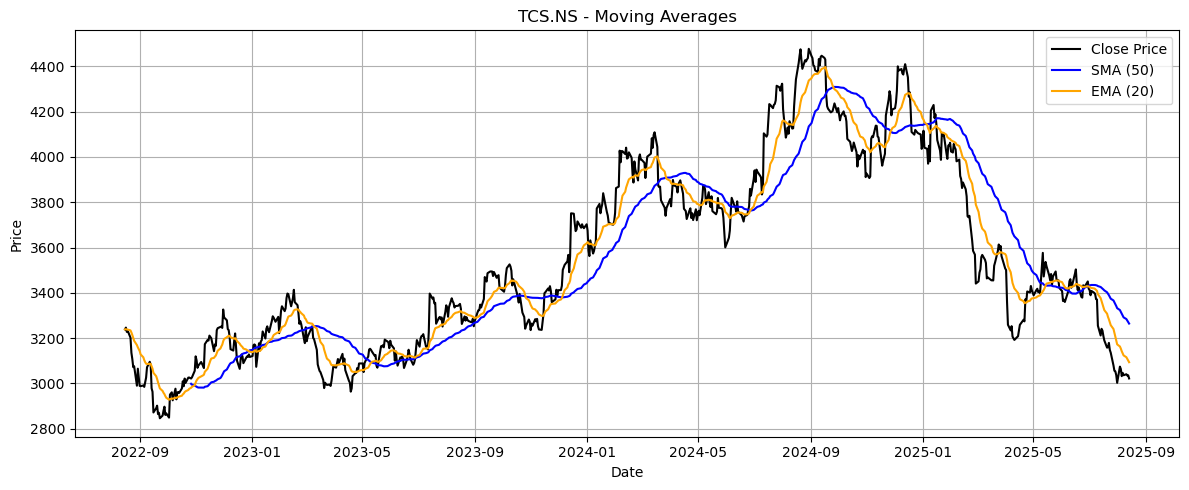

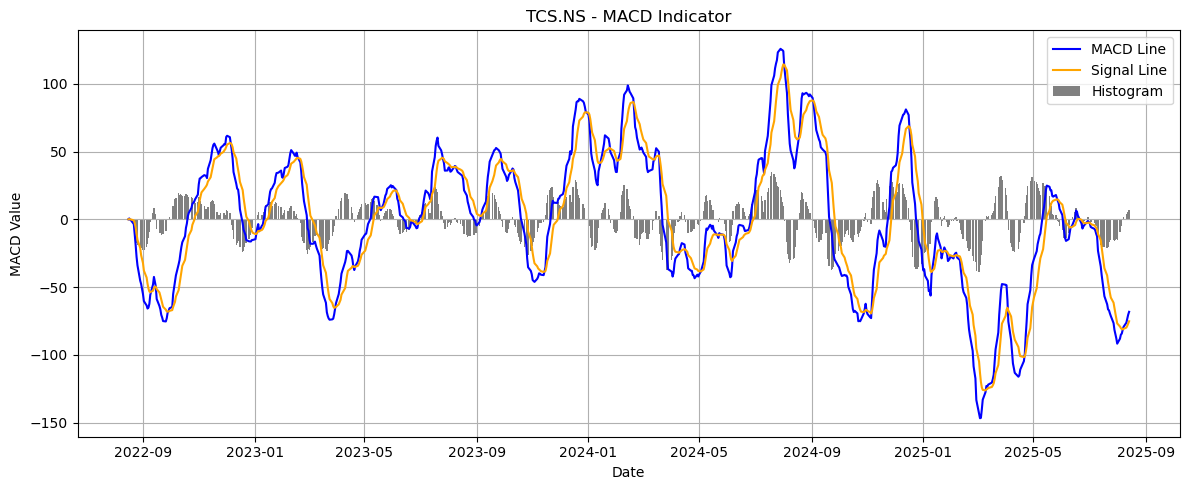

In [34]:
# Step 4: Run the module
if __name__ == "__main__":
    ticker = 'TCS.NS'
    df = fetch_data(ticker,'3y','1d')

    run_pipeline(ticker)
    
    df = calculate_ma(df)
    plot_ma(df, ticker)

    df = calculate_macd(df)
    plot_macd(df, ticker)